# Problem 1

Import necessary modules and set parameters.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

lr = 0.001
batch_size = 100
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step 1

Load datasets.

In [2]:
# MNIST dataset
dataset = datasets.MNIST(root='./mnist_data/',
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [50000, 10000])

test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False, 
                              transform=transforms.ToTensor())

# KMNIST dataset, only need test dataset
anomaly_dataset = datasets.KMNIST(root='./kmnist_data/',
                              train=False, 
                              transform=transforms.ToTensor(),
                              download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST\raw\train-images-idx3-ubyte.gz to ./mnist_data/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist_data/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST\raw



  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting ./kmnist_data/KMNIST\raw\train-images-idx3-ubyte.gz to ./kmnist_data/KMNIST\raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting ./kmnist_data/KMNIST\raw\train-labels-idx1-ubyte.gz to ./kmnist_data/KMNIST\raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting ./kmnist_data/KMNIST\raw\t10k-images-idx3-ubyte.gz to ./kmnist_data/KMNIST\raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting ./kmnist_data/KMNIST\raw\t10k-labels-idx1-ubyte.gz to ./kmnist_data/KMNIST\raw



### Step 2

Define encoders and decoders.

In [3]:
# Define Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        z = F.relu(self.fc3(x))
        return z

# Define Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 784)
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        x = F.sigmoid(self.fc3(z))  # to make output's pixels are 0~1
        x = x.view(x.size(0), 1, 28, 28) 
        return x

### Step 3

define loss and optimizer, and designate encoder and decoder.

In [4]:
enc = Encoder().to(device)
dec = Decoder().to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr)

### Step 4

Train data. Results are displayed in below figure.

0th epoch starting.


c:\Users\cjhy29\Anaconda3\envs\RL\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1th epoch starting.ing batch #499 reconstruction loss: 0.031978
2th epoch starting.ing batch #499 reconstruction loss: 0.022704
3th epoch starting.ing batch #499 reconstruction loss: 0.018204
4th epoch starting.ing batch #499 reconstruction loss: 0.017231
5th epoch starting.ing batch #499 reconstruction loss: 0.015098
6th epoch starting.ing batch #499 reconstruction loss: 0.013482
7th epoch starting.ing batch #499 reconstruction loss: 0.013510
8th epoch starting.ing batch #499 reconstruction loss: 0.011371
9th epoch starting.ing batch #499 reconstruction loss: 0.011654
Time ellapsed in training is: 77.39564347267151n loss: 0.011139


Decoder(
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=784, bias=True)
)

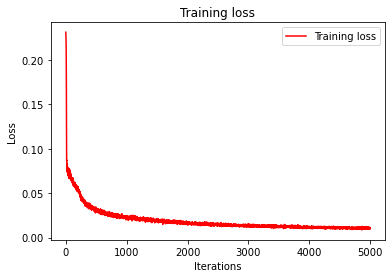

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


train_loss_list = []

import time
start = time.time()
for epoch in range(epochs) :
    print("{}th epoch starting.".format(epoch))
    enc.train()
    dec.train()
    for batch, (images, _) in enumerate(train_loader) :
        images = images.to(device)
        z = enc(images)
        reconstructed_images = dec(z)
        
        optimizer.zero_grad()
        train_loss = loss_function(images, reconstructed_images)
        train_loss.backward()
        train_loss_list.append(train_loss.item())

        optimizer.step()

        print(f"[Epoch {epoch:3d}] Processing batch #{batch:3d} reconstruction loss: {train_loss.item():.6f}", end='\r')
end = time.time()
print("Time ellapsed in training is: {}".format(end - start))

# plotting train loss
plt.plot(range(1,len(train_loss_list)+1), train_loss_list, 'r', label='Training loss')
plt.title('Training loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')

enc.eval()
dec.eval()

### Step 5

Make use of validation set to set threshold.

In [17]:
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size)

validation_loss_list = []
with torch.no_grad():
    for images, _ in validation_loader:
        images = images.to(device)
        z = enc(images)
        reconstructed_images = dec(z)
        reconstructed_images = reconstructed_images

        validation_loss_list.append(nn.MSELoss()(images, reconstructed_images).to('cpu').item())    # dim = 0
    validation_loss_list = np.array(validation_loss_list)**2

mean, std = np.mean(validation_loss_list), np.std(validation_loss_list)

threshold = mean + 3 * std
print("threshold: ", threshold)

threshold:  0.00015767693192594964


### Step 6

Now we evaluate our network. Type 1 error occurs when our network recovers original data not neatly, i.e., when loss exceeds threshold.  
The result is almost closed to usual p-value 0.05.

In [18]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

test_loss_list = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        z = enc(images)
        reconstructed_images = dec(z)
        reconstructed_images = reconstructed_images

        test_loss_list.append(nn.MSELoss()(images, reconstructed_images).to('cpu').item())    # dim = 0
    test_loss_list = np.array(test_loss_list)**2

print("total number of MNIST test set: ", len(test_loss_list), end=", ")
anomalies = test_loss_list[test_loss_list > threshold]
print("number of MNIST anomalies: ", len(anomalies), "  =>  type 1 error = ", len(anomalies)/len(test_loss_list))

total number of MNIST test set:  100, number of MNIST anomalies:  5   =>  type 1 error =  0.05


### Step 7

We also take test for KMNIST data. The result is almost same (actually same, since ...044 happens because of floating point).  
This means, our auto-encoder works well for KMNIST dataset.

In [19]:
anomaly_loader = torch.utils.data.DataLoader(dataset=anomaly_dataset, batch_size=batch_size)

test_loss_list_2 = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        z = enc(images)
        reconstructed_images = dec(z)
        reconstructed_images = reconstructed_images

        test_loss_list_2.append(nn.MSELoss()(images, reconstructed_images).to('cpu').item())    # dim = 0
    test_loss_list_2 = np.array(test_loss_list_2)**2

print("total number of KMNIST test set: ", len(test_loss_list), end=", ")
non_anomalies = test_loss_list[test_loss_list < threshold]
print("number of KMNIST non-anomalies: ", len(non_anomalies), "  =>  type 2 error = ", 1 - len(non_anomalies)/len(test_loss_list_2))

total number of KMNIST test set:  100, number of KMNIST non-anomalies:  95   =>  type 2 error =  0.050000000000000044
